In [12]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn

# 加载CSV文件
data = pd.read_csv('/Users/curryyang/code/2024_MCM_C_UESTC/processed_datasets/male_processed.csv')  # 确保这里的路径是正确的

# 提取指定行的数据
rows_to_use = list(range(1, 302)) + list(range(3790, 4015)) + list(range(5709, 5898)) + list(range(6591, 6750))
rows_to_use_1 = list(range(3623, 3789)) + list(range(5438, 5708)) + list(range(6374, 6590)) + list(range(6750, 6951))
train_data = data.iloc[rows_to_use]
train_data_1 = data.iloc[rows_to_use_1]

# 测试集 - 最后一场比赛的数据
test_data = data.iloc[6952:7286]

# 预处理p1_score，将"AD"替换为40
train_data['p1_score'] = train_data['p1_score'].replace('AD', 40).astype(int)
test_data['p1_score'] = test_data['p1_score'].replace('AD', 40).astype(int)
train_data_1['p2_score'] = train_data_1['p2_score'].replace('AD', 40).astype(int)
test_data['p2_score'] = test_data['p2_score'].replace('AD', 40).astype(int)
# 提取p1_score作为训练和测试数据
train_scores = train_data['p1_score'].values
test_scores = test_data['p1_score'].values

# 提取p2_score作为训练和测试数据
train_scores_1 = train_data_1['p2_score'].values
test_scores_1 = test_data['p2_score'].values

# 数据归一化
scaler = MinMaxScaler(feature_range=(-1, 1))
train_scores_normalized = scaler.fit_transform(train_scores.reshape(-1, 1))
test_scores_normalized = scaler.transform(test_scores.reshape(-1, 1))
# 数据归一化plaer2
scaler = MinMaxScaler(feature_range=(-1, 1))
train_scores_normalized_1 = scaler.fit_transform(train_scores_1.reshape(-1, 1))
test_scores_normalized_1 = scaler.transform(test_scores_1.reshape(-1, 1))
# 转换为PyTorch张量
train_scores_normalized = torch.FloatTensor(train_scores_normalized).view(-1)
test_scores_normalized = torch.FloatTensor(test_scores_normalized).view(-1)
# 转换为PyTorch张量player2
train_scores_normalized_1 = torch.FloatTensor(train_scores_normalized_1).view(-1)
test_scores_normalized_1 = torch.FloatTensor(test_scores_normalized_1).view(-1)


/var/folders/s0/_m13xvgj0y9_pg386fxb3g5w0000gn/T/ipykernel_20902/2688519852.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['p1_score'] = train_data['p1_score'].replace('AD', 40).astype(int)
/var/folders/s0/_m13xvgj0y9_pg386fxb3g5w0000gn/T/ipykernel_20902/2688519852.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['p1_score'] = test_data['p1_score'].replace('AD', 40).astype(int)
/var/folders/s0/_m13xvgj0y9_pg386fxb3g5w0000gn/T/ipykernel_20902/2688519852.py:22: SettingWithCopyWa

In [13]:
class CNNLSTMModel(nn.Module):
    def __init__(self, hidden_layer_size=50):
        super(CNNLSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size  # 添加hidden_layer_size属性
        
        # 定义模型层
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.lstm = nn.LSTM(input_size=64, hidden_size=self.hidden_layer_size, num_layers=1, batch_first=True)
        self.linear = nn.Linear(in_features=self.hidden_layer_size, out_features=1)

    def forward(self, x):
        #x = x.unsqueeze(1)  # 添加channel维度
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.transpose(1, 2)  # 调整维度以适应LSTM的输入要求
        lstm_out, _ = self.lstm(x)
        predictions = self.linear(lstm_out[:, -1, :])  # 只使用序列的最后一个输出
        return predictions


In [14]:
# 定义训练数据加载器
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

# 设定时间窗口大小
train_window = 5
test_window = 5

# 创建训练序列
train_inout_seq = create_inout_sequences(train_scores_normalized, train_window)
test_inout_seq = create_inout_sequences(test_scores_normalized, test_window)
# 创建训练序列player2
train_inout_seq_1 = create_inout_sequences(train_scores_normalized_1, train_window)
test_inout_seq_1 = create_inout_sequences(test_scores_normalized_1, test_window)



In [15]:
def train_model(model, train_inout_seq, epochs=10, lr=0.001):
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []  # 用于收集每个epoch的损失值

    for epoch in range(epochs):
        total_loss = 0
        for seq, labels in train_inout_seq:
            optimizer.zero_grad()
            seq = seq.view(-1, 1, train_window)
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()
            total_loss += single_loss.item()
        
        avg_loss = total_loss / len(train_inout_seq)
        losses.append(avg_loss)
        print(f'epoch: {epoch+1} loss: {avg_loss:.8f}')
    
    return losses


epoch: 1 loss: 0.53186122
epoch: 2 loss: 0.45643683
epoch: 3 loss: 0.44349267
epoch: 4 loss: 0.43673957
epoch: 5 loss: 0.43172406
epoch: 6 loss: 0.42765986
epoch: 7 loss: 0.42416568
epoch: 8 loss: 0.42103065
epoch: 9 loss: 0.41797815
epoch: 10 loss: 0.41510082
epoch: 11 loss: 0.41218022
epoch: 12 loss: 0.40970397
epoch: 13 loss: 0.40715793
epoch: 14 loss: 0.40493934
epoch: 15 loss: 0.40307636
epoch: 16 loss: 0.40151108
epoch: 17 loss: 0.40012910
epoch: 18 loss: 0.39874921
epoch: 19 loss: 0.39759148
epoch: 20 loss: 0.39662596
epoch: 21 loss: 0.39555790
epoch: 22 loss: 0.39473512
epoch: 23 loss: 0.39386647
epoch: 24 loss: 0.39310319
epoch: 25 loss: 0.39235185
epoch: 26 loss: 0.39171193
epoch: 27 loss: 0.39099190
epoch: 28 loss: 0.39029676
epoch: 29 loss: 0.38963257
epoch: 30 loss: 0.38904672
epoch: 31 loss: 0.38843289
epoch: 32 loss: 0.38787806
epoch: 33 loss: 0.38743829
epoch: 34 loss: 0.38690096
epoch: 35 loss: 0.38649305
epoch: 36 loss: 0.38609590
epoch: 37 loss: 0.38578255
epoch: 38 

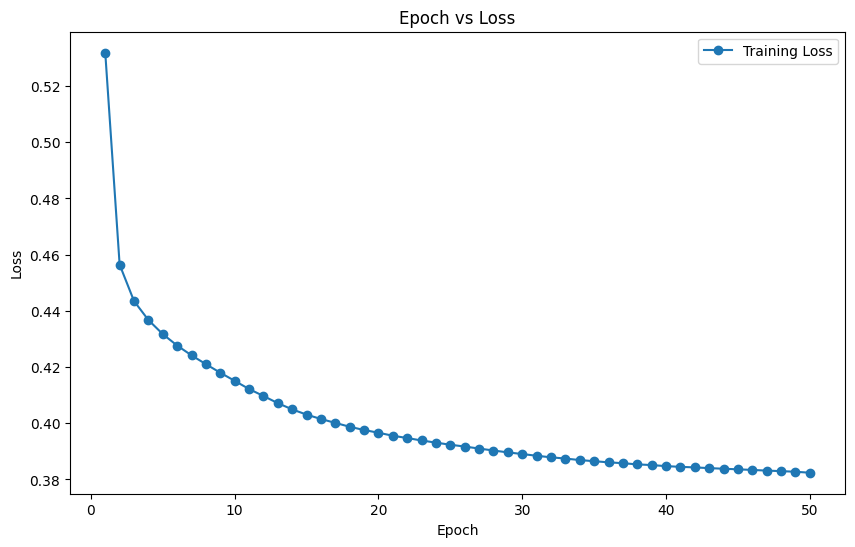

In [10]:
import matplotlib.pyplot as plt

# 实例化并训练模型
model = CNNLSTMModel()
losses = train_model(model, train_inout_seq, epochs=50, lr=0.001)

# 绘制训练损失曲线
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses)+1), losses, marker='o', label='Training Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


/Users/curryyang/anaconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 1 loss: 0.53005730
epoch: 2 loss: 0.43354657
epoch: 3 loss: 0.40791473
epoch: 4 loss: 0.39273700
epoch: 5 loss: 0.38185429
epoch: 6 loss: 0.37387837
epoch: 7 loss: 0.36798713
epoch: 8 loss: 0.36350053
epoch: 9 loss: 0.35985487
epoch: 10 loss: 0.35676537
epoch: 11 loss: 0.35420666
epoch: 12 loss: 0.35205803
epoch: 13 loss: 0.35012093
epoch: 14 loss: 0.34842476
epoch: 15 loss: 0.34686669
epoch: 16 loss: 0.34548682
epoch: 17 loss: 0.34418035
epoch: 18 loss: 0.34302532
epoch: 19 loss: 0.34198126
epoch: 20 loss: 0.34106759
epoch: 21 loss: 0.34019934
epoch: 22 loss: 0.33945270
epoch: 23 loss: 0.33890053
epoch: 24 loss: 0.33827766
epoch: 25 loss: 0.33776641
epoch: 26 loss: 0.33731477
epoch: 27 loss: 0.33692120
epoch: 28 loss: 0.33642200
epoch: 29 loss: 0.33612506
epoch: 30 loss: 0.33573180
epoch: 31 loss: 0.33535416
epoch: 32 loss: 0.33507186
epoch: 33 loss: 0.33482729
epoch: 34 loss: 0.33454329
epoch: 35 loss: 0.33426145
epoch: 36 loss: 0.33404781
epoch: 37 loss: 0.33382672
epoch: 38 

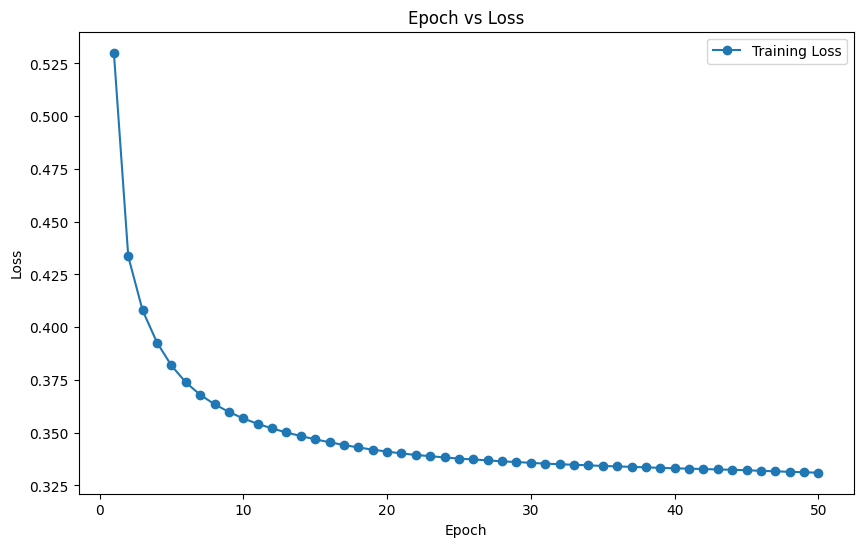

In [18]:
# 实例化并训练模型player2
import matplotlib.pyplot as plt

# 实例化并训练模型
model_1 = CNNLSTMModel()
losses_1 = train_model(model_1, train_inout_seq_1, epochs=50, lr=0.001)

# 绘制训练损失曲线
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses_1)+1), losses_1, marker='o', label='Training Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

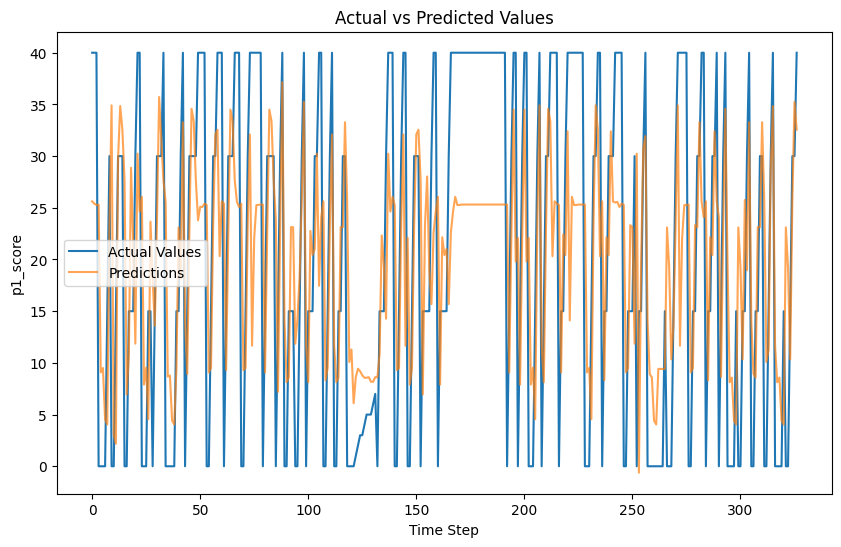

In [11]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for seq, true_val in test_inout_seq:  # 确保test_inout_seq已准备好
        seq = seq.view(-1, 1, train_window)
        prediction = model(seq)
        prediction = scaler.inverse_transform(prediction.numpy().reshape(-1, 1))
        true_val = scaler.inverse_transform(true_val.numpy().reshape(-1, 1))

        # 检查prediction是否包含多个值
        if prediction.size > 1:
            predictions.extend(prediction.squeeze().tolist())
        else:
            predictions.append(prediction.item())  # 直接添加单个预测值

        # 对于实际值执行相同的检查
        if true_val.size > 1:
            actuals.extend(true_val.squeeze().tolist())
        else:
            actuals.append(true_val.item())

# 绘制测试集拟合曲线
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Values')
plt.plot(predictions, label='Predictions', alpha=0.7)
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('p1_score')
plt.legend()
plt.show()


In [ ]:
model_1.eval()
predictions_1 = []
actuals_1 = []

with torch.no_grad():
    for seq, true_val in test_inout_seq:  # 确保test_inout_seq已准备好
        seq = seq.view(-1, 1, train_window)
        prediction = model(seq)
        prediction = scaler.inverse_transform(prediction.numpy().reshape(-1, 1))
        true_val = scaler.inverse_transform(true_val.numpy().reshape(-1, 1))

        # 检查prediction是否包含多个值
        if prediction.size > 1:
            predictions.extend(prediction.squeeze().tolist())
        else:
            predictions.append(prediction.item())  # 直接添加单个预测值

        # 对于实际值执行相同的检查
        if true_val.size > 1:
            actuals.extend(true_val.squeeze().tolist())
        else:
            actuals.append(true_val.item())

# 绘制测试集拟合曲线
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Values')
plt.plot(predictions, label='Predictions', alpha=0.7)
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('p1_score')
plt.legend()
plt.show()
